In [2]:
# import all necessary libraries
import pickle
import os
import pyabf
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import ttk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
# Define functions for the analysis software



def searchPickle(picklename):
    # check if our pickle file is there and load it, otherwise create it
    if os.path.isfile(f"{picklename}.pickle"):
        # if it exists, load it
        with open(f"{picklename}.pickle", "rb") as f:
            spike_dict = pickle.load(f)
        # else create it and store the dict spike_dict in it
    else:
        # create a dictionary
        spike_dict = {}
        with open(f"{picklename}.pickle", "wb") as f:
            pickle.dump(spike_dict, f)
    
    return spike_dict

def savePickle(picklename, spike_dict, random_spikes, is_spike):
    # input spikes into dictionary
    for i in range(len(is_spike)):
        spike_dict[random_spikes[i]] = is_spike[i]

    # Save the dictionary as a pickle file
    with open(f"{picklename}.pickle", "wb") as f:
                pickle.dump(spike_dict, f)
                
    return spike_dict

def loadABF(abf_filename):
    abf = pyabf.ABF(abf_filename)
    cutoff_l_Hz = 200
    cutoff_r_Hz = 5000
    N_order = 3
    b, a = signal.butter(N=N_order, Wn=[cutoff_l_Hz, cutoff_r_Hz], btype='bandpass', fs=abf.sampleRate)
    filtered_mV = signal.filtfilt(b,a, abf.sweepY) # Signal filtered with butterworth bandpass filter with 200Hz and 5kHz cutof
    
    tf = abf.sweepX # timeframe recorded in sec
    raw_mV = abf.sweepY # Signal recorded
    
    return raw_mV, filtered_mV, tf

def plotTimepointXtoY(X,Y,raw_mV, filtered_mV, tf, spike_idx):
    # find the first index of tf where tf>X
    x_ind = np.where(tf>X)[0][0]
    # find the first index of tf where tf>Y
    y_ind = np.where(tf>Y)[0][0]
    # Plot a subplot with 2 rows and one column 
    # Top graph is the raw signal from x_ind to y_ind
    plt.figure(figsize=(10,5))
    plt.subplot(2, 1, 1)
    plt.plot(tf[x_ind:y_ind], raw_mV[x_ind:y_ind])
    plt.title(f"Raw signal from {X:.3f} to {Y:.3f} sec")
    plt.xlabel("Time (ms)")
    plt.ylabel("Voltage (mV)")
    # Bottom graph is the filtered signal from x_ind to y_ind
    plt.subplot(2, 1, 2)
    plt.plot(tf[x_ind:y_ind], filtered_mV[x_ind:y_ind])
    # Plot a horizontal dashed red line at the spike index
    plt.plot(tf[spike_idx], filtered_mV[spike_idx], 'ro', markersize=10, markerfacecolor='none', markeredgewidth=2)
    # title the plot "Filtered signal from X to Y" where X and Y show .2f precision
    plt.title(f"Filtered signal from {X:.3f} to {Y:.3f} sec")
    plt.xlabel("Time (ms)")
    plt.ylabel("Voltage (mV)")
    plt.tight_layout()
    plt.show()
    
def findSpikes(filtered_mV):
    '''Find spikes in the filtered signal and return the indexes of the spikes'''
    # set threshold as mean + 2.5*std
    threshold = np.mean(filtered_mV) + 2.5*np.std(filtered_mV)
    # find all indexes that cross threshold
    spike_idx = np.where(filtered_mV>threshold)[0]

    # find all local maximas with range of 5 indexes (peak not noise)
    local_maxima = signal.argrelextrema(filtered_mV, np.greater, order=5)
    # find all spike_idx that are also local_maxima
    real_spike_idx = np.intersect1d(spike_idx, local_maxima)
    return real_spike_idx

def plotSpike(spike_idx, raw_mV, filtered_mV, tf, windowsize = 0.5):
    # windowsize = size of window in msec (if windowsize = 0.2 then show 1 msec prior to spike and 1 msec after spike)
    windowsize_index = int(np.where(tf>windowsize)[0][0]/2)
    # Check if the windowsize is out of bounds for this spike index
    if spike_idx-windowsize_index < 0 or spike_idx+windowsize_index > len(tf):
        print("Spike index out of bounds")
        return
    else:
        # Plot the spike in the raw signal and the filtered signal
        plotTimepointXtoY(tf[spike_idx-windowsize_index], tf[spike_idx+windowsize_index], raw_mV, filtered_mV, tf, spike_idx)

def plot_graph(xdata, ydata, ydata2):
    print(xdata)
    fig = plt.Figure(figsize=(10, 5))
    # create ax subplot on the left
    ax = fig.add_subplot(211)
    ax.plot(xdata, ydata)
    # plot a red circle at the middle value of the xdata and ydata
    ax.plot(xdata[len(xdata)//2], ydata[len(xdata)//2], 'ro', markersize=10, markerfacecolor='none', markeredgewidth=2)
    ax.set_xlabel('tf')
    ax.set_ylabel('mV')
    # create ax2 subplot on the right that is zoomed in on the x axis by a factor of 10
    ax2 = fig.add_subplot(212)
    startindex = len(xdata)//2 - len(xdata)//20
    endindex = len(xdata)//2 + len(xdata)//20
    
    ax2.plot(xdata[startindex:endindex], ydata2[startindex:endindex])
    ax2.plot(xdata[len(xdata)//2], ydata2[len(xdata)//2], 'ro', markersize=10, markerfacecolor='none', markeredgewidth=2)
    ax.set_xlabel('tf')
    ax.set_ylabel('mV')
    return fig

def create_gui(N, start_idx, end_idx, tf, mV, mVfilt):
    def on_button_click(btn):
        nonlocal current_idx, results
        
        if btn == 'Spike':
            results[current_idx] = 1
        elif btn == 'Artifact':
            results[current_idx] = 0
            
        current_idx += 1
        if current_idx < N:
            canvas.figure = plot_graph(tf[start_idx[current_idx]:end_idx[current_idx]], mV[start_idx[current_idx]:end_idx[current_idx]], mVfilt[start_idx[current_idx]:end_idx[current_idx]])
            canvas.draw()
        else:
            root.destroy()
    
    results = np.zeros(N)
    current_idx = 0

    # Create the tkinter window
    root = tk.Tk()
    root.title("Graph Viewer")

    # Create the buttons and button box
    button_frame = ttk.Frame(root)
    spike_button = ttk.Button(button_frame, text='Spike', command=lambda: on_button_click('Spike'))
    artifact_button = ttk.Button(button_frame, text='Artifact', command=lambda: on_button_click('Artifact'))
    spike_button.grid(row=0, column=0, padx=5, pady=5)
    artifact_button.grid(row=0, column=1, padx=5, pady=5)
    button_frame.pack(side=tk.BOTTOM)

    # Display the first graph
    print(f'start index: {start_idx[current_idx]}, end index: {end_idx[current_idx]}')
    
    fig = plot_graph(tf[start_idx[current_idx]:end_idx[current_idx]], mV[start_idx[current_idx]:end_idx[current_idx]], mVfilt[start_idx[current_idx]:end_idx[current_idx]])
    canvas = FigureCanvasTkAgg(fig, master=root)
    canvas.draw()
    canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=1)

    root.mainloop()
    
    return results


In [3]:
# Load the data 
abf_filename = "2023_04_20_0004.abf"
raw_mV, filtered_mV, tf = loadABF(abf_filename)

In [4]:
# Either find spikes or use the txt file
detected_spikes = findSpikes(filtered_mV)
# detected_spikes = np.loadtxt("spike_indexes_2023_04_20.txt", dtype=int)
print(f"Detected {len(detected_spikes)} spikes")

Detected 25664 spikes


In [16]:
# check if our pickle file is there and load it, otherwise create it
picklename = 'spikes'
spike_dict = searchPickle(picklename)



# Loop through N spikes at random locations and add them to a dictionary and save the dictionary as a pickle file
N = 100
spikestart_idx =5924
want_random = 1
# for i in range(N):
#     # Get random index from 0 to length of filtered_mV
#     currentidx = np.random.randint(0, len(filtered_mV))
#     # Plot the spike with idx as the center of the spike
#     plotSpike(currentidx, raw_mV, filtered_mV, tf)
#     # Ask for userinput if this is a spike =1 or artifact = 0
    
windowsize = 0.5
windowsize_index = int(np.where(tf>windowsize)[0][0]/2)
# Popilate start_idx and end_idx with the start and end indices of some random spikes from detected_spikes
if want_random:
    random_spikes = np.random.choice(detected_spikes, N)
else:
    # take N spikes starting from spikestart_idx
    random_spikes = detected_spikes[spikestart_idx:spikestart_idx+N]
start_idx = random_spikes - windowsize_index
end_idx = random_spikes + windowsize_index
# if any start index that is <0 or end index is > len(tf) abort and show error message
if np.any(start_idx<0) or np.any(end_idx>len(tf)):
    print("Spike index out of bounds")
    exit()
else:
    is_spike = create_gui(N, start_idx, end_idx, tf, raw_mV, filtered_mV)
    print(is_spike, random_spikes)

    spike_dict = savePickle(picklename, spike_dict, random_spikes, is_spike)



start index: 25183162, end index: 25208162
[503.6632 503.6633 503.6633 ... 504.1632 504.1632 504.1632]
[607.1388 607.1388 607.1388 ... 607.6387 607.6387 607.6388]
[80.1448 80.1448 80.1449 ... 80.6448 80.6448 80.6448]
[730.5277 730.5278 730.5278 ... 731.0277 731.0277 731.0277]
[824.8986 824.8986 824.8987 ... 825.3986 825.3986 825.3986]
[453.4877 453.4877 453.4877 ... 453.9876 453.9877 453.9877]
[459.2974 459.2974 459.2974 ... 459.7973 459.7973 459.7974]
[361.8776 361.8776 361.8776 ... 362.3775 362.3775 362.3776]
[174.5624 174.5624 174.5625 ... 175.0624 175.0624 175.0624]
[728.1607 728.1607 728.1608 ... 728.6607 728.6607 728.6607]
[100.473  100.4731 100.4731 ... 100.973  100.973  100.973 ]
[342.843  342.843  342.843  ... 343.3429 343.3429 343.343 ]
[632.9457 632.9457 632.9457 ... 633.4456 633.4456 633.4456]
[675.1981 675.1982 675.1982 ... 675.6981 675.6981 675.6981]
[198.5312 198.5312 198.5313 ... 199.0312 199.0312 199.0312]
[244.6033 244.6033 244.6033 ... 245.1032 245.1033 245.1033]
[38

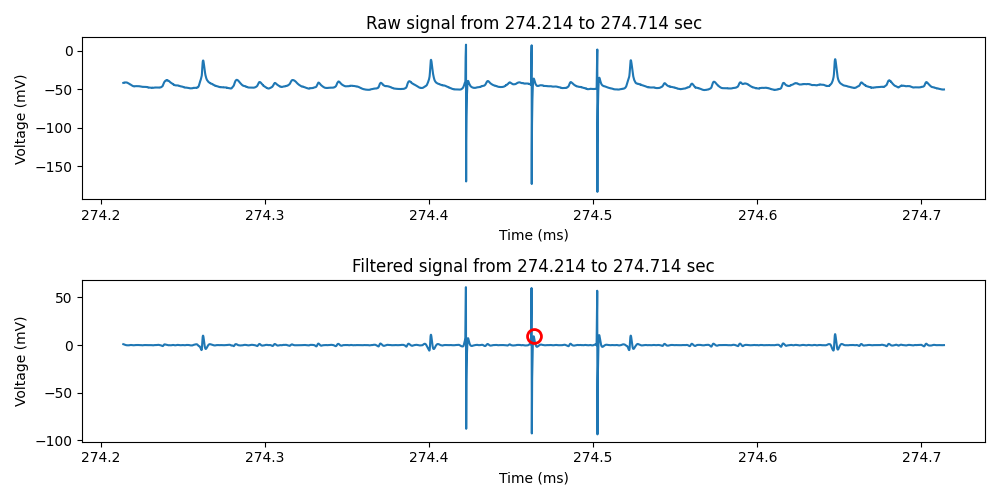

13723186 1.0


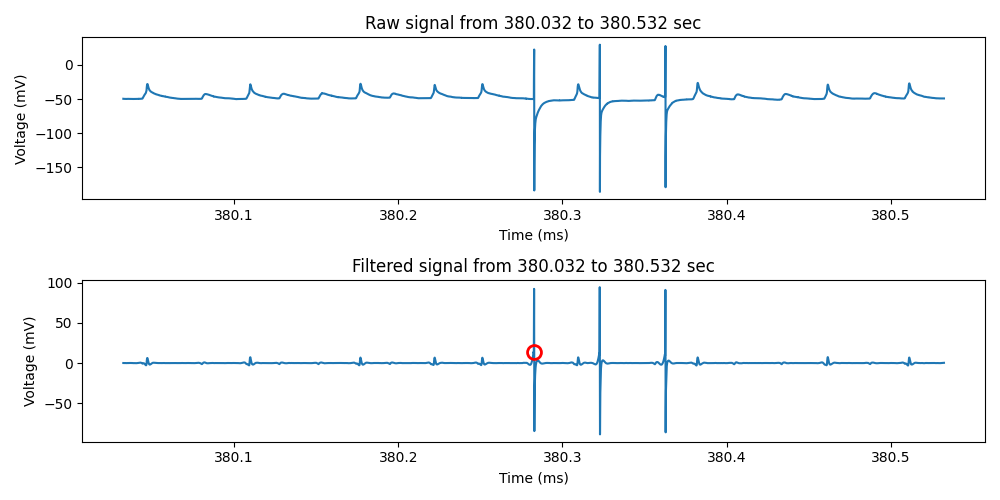

19014123 1.0


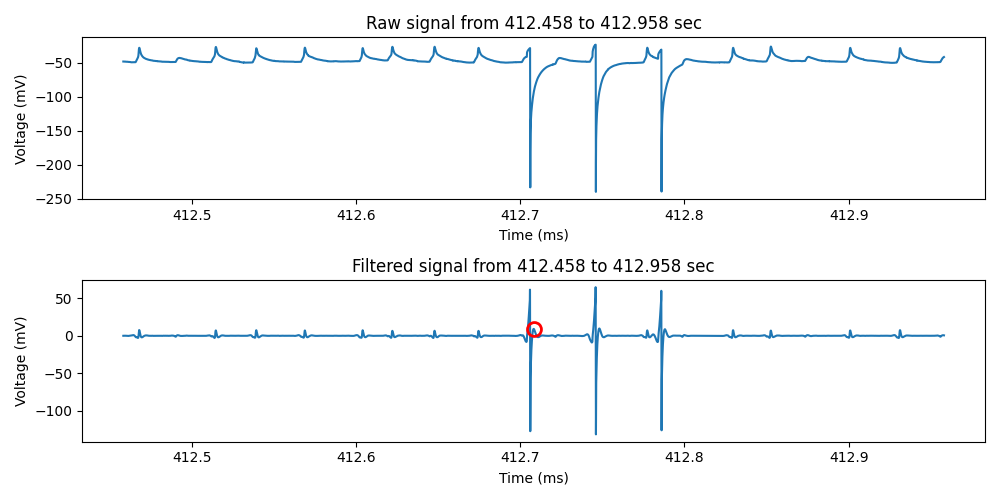

20635404 1.0


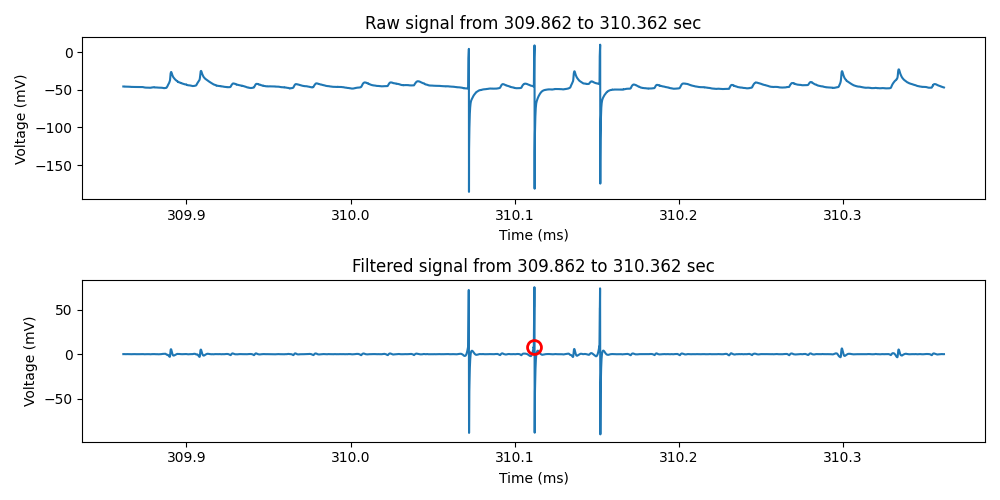

15505578 1.0


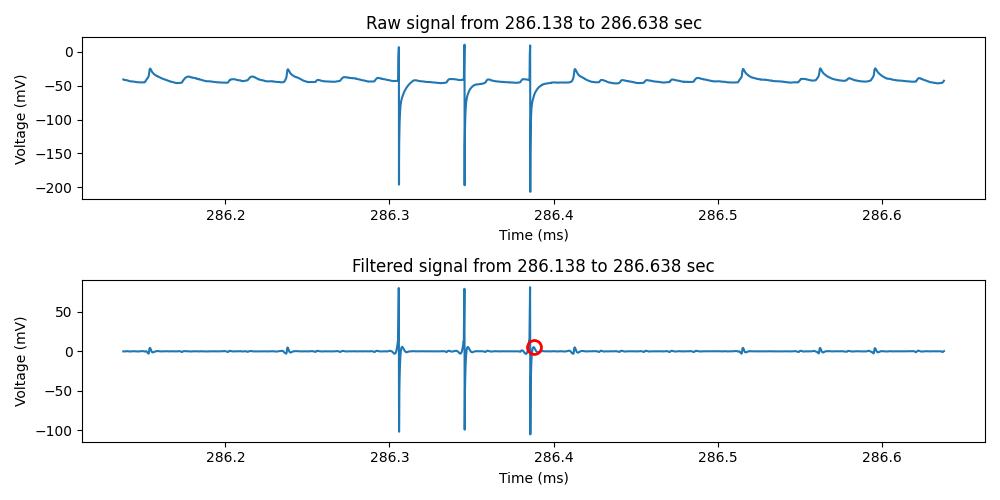

14319391 1.0


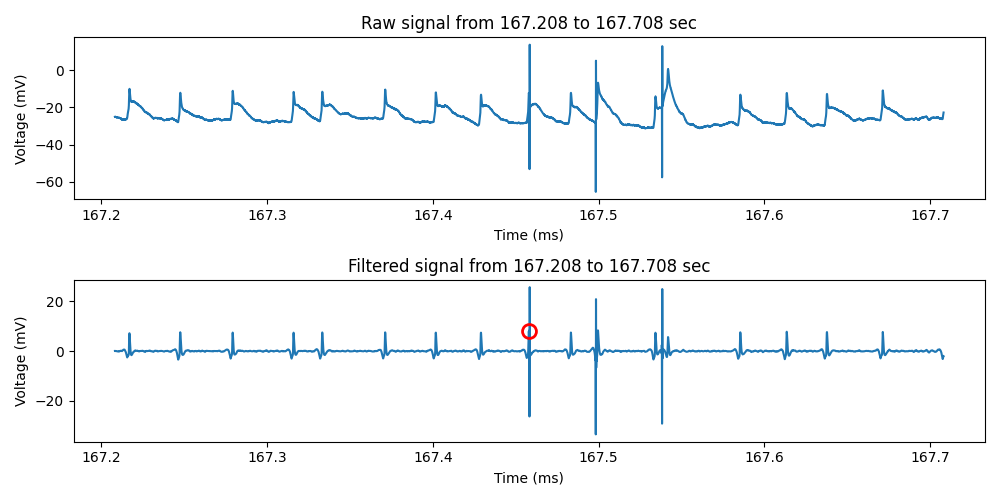

8372909 1.0


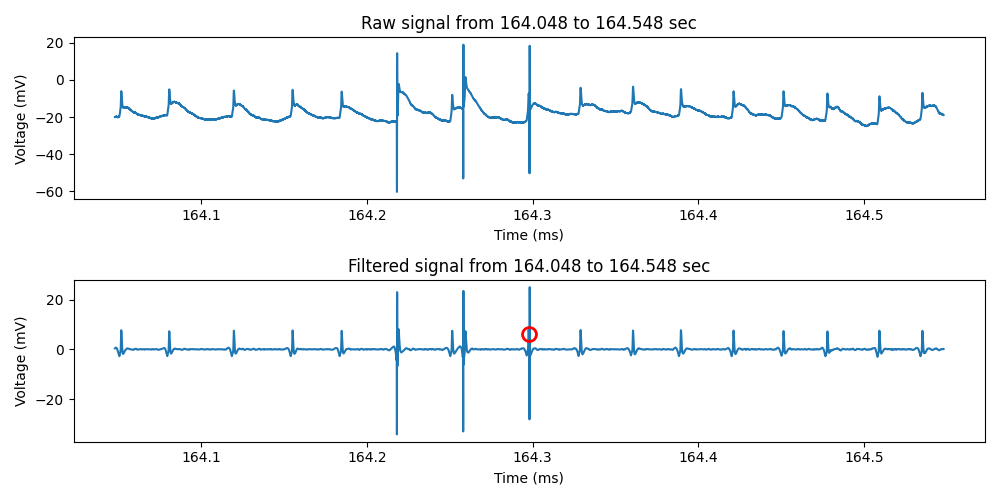

8214901 1.0


In [22]:
%matplotlib widget



# loop through the dictionary for values == 0 and plot the spike
for key in [13723186 ,19014123,20635404,15505578 ,14319391 ,8372909 ,8214901]:
        plotSpike(key, raw_mV, filtered_mV, tf)
        print(key, value)

In [23]:
# change pickle to account for errors
spike_dict[8372909] = 1
# save spike_dict as picklename
spike_dict = savePickle(picklename, spike_dict, [], [])

{8045134: 1.0,
 8046923: 1.0,
 8048710: 1.0,
 8048908: 0.0,
 8049017: 1.0,
 8050831: 1.0,
 8050907: 0.0,
 8052406: 1.0,
 8052907: 0.0,
 8052962: 1.0,
 8054699: 1.0,
 8056431: 1.0,
 8057517: 1.0,
 8059073: 1.0,
 8060567: 1.0,
 8061782: 1.0,
 8063431: 1.0,
 8064819: 1.0,
 8066344: 1.0,
 8067564: 1.0,
 8068896: 1.0,
 8070183: 1.0,
 8071741: 1.0,
 8073034: 1.0,
 8074491: 1.0,
 8075847: 1.0,
 8077962: 1.0,
 8079494: 1.0,
 8080769: 1.0,
 8081866: 1.0,
 8083256: 1.0,
 8085223: 1.0,
 8086943: 1.0,
 8088397: 1.0,
 8089949: 1.0,
 8091273: 1.0,
 8092431: 1.0,
 8094011: 1.0,
 8095692: 1.0,
 8097244: 1.0,
 8098843: 1.0,
 8100278: 1.0,
 8102213: 1.0,
 8102910: 0.0,
 8102964: 1.0,
 8104910: 0.0,
 8104960: 1.0,
 8106764: 1.0,
 8106910: 0.0,
 8108620: 1.0,
 8110897: 1.0,
 8112162: 1.0,
 8113800: 1.0,
 8115079: 1.0,
 8116544: 1.0,
 8118490: 1.0,
 8120099: 1.0,
 8121530: 1.0,
 8123061: 1.0,
 8124775: 1.0,
 8126395: 1.0,
 8128073: 1.0,
 8129360: 1.0,
 8131232: 1.0,
 8133049: 1.0,
 8135039: 1.0,
 8136389: 

In [18]:
# check length of spike_dict
print(f"Length of spike_dict: {len(spike_dict)}")
# print how many values are 1 and how many are 0
print(f"Number of spikes: {np.sum(list(spike_dict.values()))}")
print(f"Number of artifacts: {len(spike_dict) - np.sum(list(spike_dict.values()))}")

Length of spike_dict: 687
Number of spikes: 640.0
Number of artifacts: 47.0


In [103]:
# Print the number of spikes in the dictionary, and number per type
print(f"Total number of spikes: {len(spike_dict)}, number of spikes: {sum(spike_dict.values())}, number of artifacts: {len(spike_dict)-sum(spike_dict.values())}")

Total number of spikes: 300, number of spikes: 274.0, number of artifacts: 26.0


In [104]:
### Train a network to differentiate between spikes and artifacts based on features
#need torch
import torch
# Load the data using the pickle file
picklename = 'spikes'
spike_dict = searchPickle(picklename)

# create empty np.array for features of shape (len(spike_dict), nFeatures)
featurewindow = 0.0005 # in seconds
featurewindowend = int(np.where(tf>featurewindow)[0][0]/2)
nFeatures = featurewindowend*2

features_raw = np.zeros((len(spike_dict), nFeatures))
features_filt = np.zeros((len(spike_dict), nFeatures))
labels = np.zeros(len(spike_dict))

# Use the keys of the dictionary as indexes to create feature tensor and label tensor based on the dict key value
for i in range(len(spike_dict)):
    key = list(spike_dict.keys())[i]
    # create feature array that goes from key-featurewindowend to key+featurewindowend from raw_mV and filtered_mV
    features_raw[i,:] = raw_mV[key-featurewindowend:key+featurewindowend]
    features_filt[i,:] = filtered_mV[key-featurewindowend:key+featurewindowend]        
    labels[i] = spike_dict[key]


###
# Standardize all features
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# scaler = StandardScaler()
#  Try a different scaler
scaler = MinMaxScaler()
scaled_features_raw = scaler.fit_transform(features_raw)
scaled_features_filt = scaler.fit_transform(features_filt)

# normalize all features such that the middle value =0
middleindex = int(nFeatures/2)
for i in range(len(scaled_features_raw)):
    scaled_features_raw[i,:] = scaled_features_raw[i,:] - scaled_features_raw[i,middleindex]
    scaled_features_filt[i,:] = scaled_features_filt[i,:] - scaled_features_filt[i,middleindex]

# Concat scaled_features_raw and scaled_features_filt to create the features tensor
features = np.concatenate((scaled_features_raw, scaled_features_filt), axis=1)

# convert from numpy to tensor
features = torch.from_numpy(features).float()
labels = torch.from_numpy(labels).long()

print(features.shape)

# Perform undersampling so that equal number of spikes and artifacts are in the dataset
# Get the indexes of spikes and artifacts
spike_idx = np.where(labels==1)[0]
artifact_idx = np.where(labels==0)[0]

# Get the lower number of spikes and artifacts
Numbertoget = np.min([len(spike_idx), len(artifact_idx)])
newfeatures = np.zeros((Numbertoget*2, nFeatures*2))
newlabels = np.zeros(Numbertoget*2)
for i in range(Numbertoget):
    # randomly pick a spike and artifact index
    randspike = np.random.choice(spike_idx)
    randartifact = np.random.choice(artifact_idx)
    # add the features and labels to the newfeatures and newlabels
    newfeatures[i,:] = features[randspike,:]
    newfeatures[i+Numbertoget,:] = features[randartifact,:]
    newlabels[i] = labels[randspike]
    newlabels[i+Numbertoget] = labels[randartifact]

# convert from numpy to tensor
features = torch.from_numpy(newfeatures).float()
labels = torch.from_numpy(newlabels).long()

###
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(features, labels, test_size=.2)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects
batchsize    = 22
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0]) # how big should these batches be??

torch.Size([300, 52])


In [107]:
# print how many batches are in the train_loader, and a vector of how many test_labels == 0 in each batch
print(len(train_loader))
for i, (data, labels_tg) in enumerate(train_loader):
    print(i, torch.sum(labels_tg==0))

print(f'Number of spikes: {np.sum(labels.numpy())}, Number of artifacts: {len(labels)-np.sum(labels.numpy())}')
print(f'number of features per spike: {len(scaled_features_raw[0,:])}')

2
0 tensor(12)
1 tensor(10)
Number of spikes: 26, Number of artifacts: 26
number of features per spike: 26


NeuralNet(
  (input): Linear(in_features=52, out_features=26, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (hidden1): Linear(in_features=26, out_features=13, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (hidden2): Linear(in_features=13, out_features=6, bias=True)
  (output): Linear(in_features=6, out_features=2, bias=True)
)


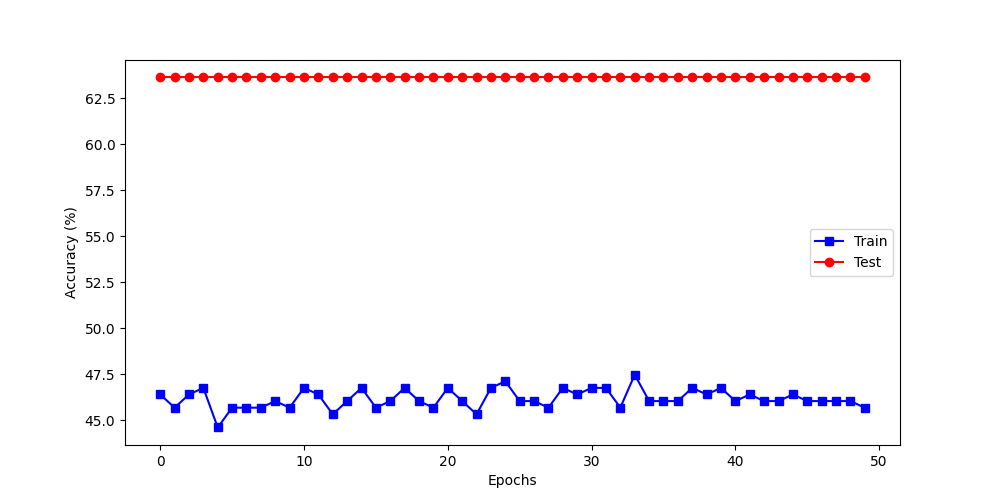

In [108]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

# Create ANN Class
class NeuralNet(nn.Module):
  def __init__(self, inputsize):
    super().__init__()
    
    # Layers
    self.input = nn.Linear(inputsize, int(inputsize/2))
    self.dropout1 = nn.Dropout(0.5)
    self.hidden1 = nn.Linear(int(inputsize/2), int(inputsize/4))
    self.dropout2 = nn.Dropout(0.5)
    self.hidden2 = nn.Linear(int(inputsize/4), int(inputsize/8))
    self.output = nn.Linear(int(inputsize/8), 2)
    
  def forward(self, x):
    
    x = F.relu(self.input(x))
    x = self.dropout1(x)
    x = F.relu(self.hidden1(x))
    x = self.dropout2(x)
    x = F.relu(self.hidden2(x))
    x = self.output(x)
    return x
    
# Create the Neural Network Model
def create_model(inputsize):
  # grab an instance of the model class
  model = NeuralNet(inputsize)
  # define the loss function
  loss_function = nn.CrossEntropyLoss()
  # define the optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  
  return model, loss_function, optimizer

# Train the Neural Network Model
def train_neuralnetwork(model, loss_function, optimizer, num_epochs):
  
  # Store training Accuracy
  trainAcc = []
  # Store testing Accuracy
  testAcc = []
  
  # loop over the epochs
  for i in range(num_epochs):
    # loop over training data batches
    batchAcc = []
    for X, y in train_loader:
      
      # forward pass
      y_hat = model(X)
      # calculate loss
      loss = loss_function(y_hat, y)
      
      # zero the parameter gradients
      optimizer.zero_grad()      
      # backward pass
      loss.backward()
      # update parameters
      optimizer.step()
      
      # compute training accuracy just for this batch
      batchAcc.append( 100*torch.mean((torch.argmax(y_hat,axis=1) == y).float()).item() )
      
    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )
    
    # test accuracy
    model.eval()
    X, y = next(iter(test_loader))
    pred = torch.argmax(model(X), axis=1)
    testAcc.append( 100*torch.mean((pred == y).float()).item() )
  return trainAcc, testAcc

# Create the model
SpikeArtifactSeparator, loss_function, optimizer = create_model(features.shape[1])
print(SpikeArtifactSeparator)
# Train the model
trainAcc, testAcc = train_neuralnetwork(SpikeArtifactSeparator, loss_function, optimizer, num_epochs = 50)
# Save the trained model
torch.save(SpikeArtifactSeparator.state_dict(), 'spike_artifact_separator.pth')

# Plot the training and testing accuracy
fig = plt.figure(figsize=(10,5))

plt.plot(trainAcc,'bs-')
plt.plot(testAcc,'ro-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])

plt.show()

# Test different hyperparameters

# Package the neural network model: Save your trained neural network model 
# (e.g., using Keras, TensorFlow, or PyTorch) to a file format that can be easily loaded, 
# such as an H5 file for Keras, a PB file for TensorFlow, or a PT file for PyTorch.

# Create an API: Develop a RESTful API using a web framework like Flask or FastAPI in Python. 
# This API will act as an interface between the user (your colleague) and the neural network function. 
# The API should be able to accept a CSV file, preprocess it as needed, and send it to the 
# neural network function for processing. The API should also be able to return the output vector as a response, 
# either as JSON or as a downloadable CSV file.

# API endpoint for file upload: Design an API endpoint to accept a file upload (e.g., a CSV file). 
# You can use the request library in Flask or FastAPI to handle file uploads. Once the file is received, 
# you'll need to convert it into the appropriate format for your neural network function.

# Preprocessing: Depending on your neural network function's input requirements, 
# you might need to preprocess the input data. For example, you may need to normalize or standardize the data 
# or handle missing values. Include this preprocessing step in your API.

# Deploy the API: Deploy your API on a cloud platform or a server, such as AWS, Google Cloud, or Heroku. 
# This will make your API accessible to your colleague through a public or private URL.

# Create client-side code or a user interface (optional): You can create a simple HTML/JavaScript web page 
# or a Python script that allows your colleague to upload the CSV file and interact with your API. 
# This would make it even more convenient for them to use your neural network function without needing to know the underlying code.

#





In [109]:
# make a np array of the features of ALL spikes in detected_spikes

# start by creating an matrix of zeros with the right dimensions (rows = len(detected_spikes), columns = len of both features_raw and features_filt)

all_features_raw = np.zeros((len(detected_spikes), len(features_raw[0,:])))
all_features_filt = np.zeros((len(detected_spikes), len(features_filt[0,:])))


for Nspike in range(len(detected_spikes)):
    key = detected_spikes[Nspike]
    # create feature array that goes from key-featurewindowend to key+featurewindowend from raw_mV and filtered_mV
    all_features_raw[Nspike, :] = raw_mV[key-featurewindowend:key+featurewindowend]
    all_features_filt[Nspike, :] = filtered_mV[key-featurewindowend:key+featurewindowend]


# for Nspike in range(len(detected_spikes)):
#     key = detected_spikes[i]
#     # create feature array that goes from key-featurewindowend to key+featurewindowend from raw_mV and filtered_mV
#     all_features_raw[i,:] = raw_mV[key-featurewindowend:key+featurewindowend]
#     all_features_filt[i,:] = filtered_mV[key-featurewindowend:key+featurewindowend]   

# Standardize all features
from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
#  Try a different scaler
scaler = MinMaxScaler()
all_features_raw = scaler.fit_transform(all_features_raw)
all_features_filt = scaler.fit_transform(all_features_filt)

# normalize all features such that the middle value =0
middleindex = int(nFeatures/2)
for i in range(len(all_features_raw)):
    all_features_raw[i,:] = all_features_raw[i,:] - all_features_raw[i,middleindex]
    all_features_filt[i,:] = all_features_filt[i,:] - all_features_filt[i,middleindex]

# concat all_features_raw and all_features_filt to create the features tensor
all_features = np.concatenate((all_features_raw, all_features_filt), axis=1)

# initialize a labels np.array of zeros with the right dimensions (rows = len(detected_spikes), columns = 1)
all_labels = np.zeros((len(detected_spikes), 1))

# convert from numpy to tensor
all_features = torch.from_numpy(all_features).float()
all_labels = torch.from_numpy(all_labels).long()

# predict all_labels using the model and the features tensor get the argmax of SpikeArtifactSeparator2(features)
# Load the trained model
SpikeArtifactSeparator_loaded = NeuralNet(features.shape[1])
SpikeArtifactSeparator_loaded.load_state_dict(torch.load('spike_artifact_separator.pth'))
SpikeArtifactSeparator_loaded.eval()
labels_hat = torch.argmax(SpikeArtifactSeparator_loaded(all_features), axis=1)




In [34]:
# TO DO:
# Go through all spikes labeled 1 and throw away spikes that are within 1ms of each other
true_spikes = []
minISI = np.where(tf>0.001)[0][0]
# for i in range(len(detected_spikes)):
#     s#

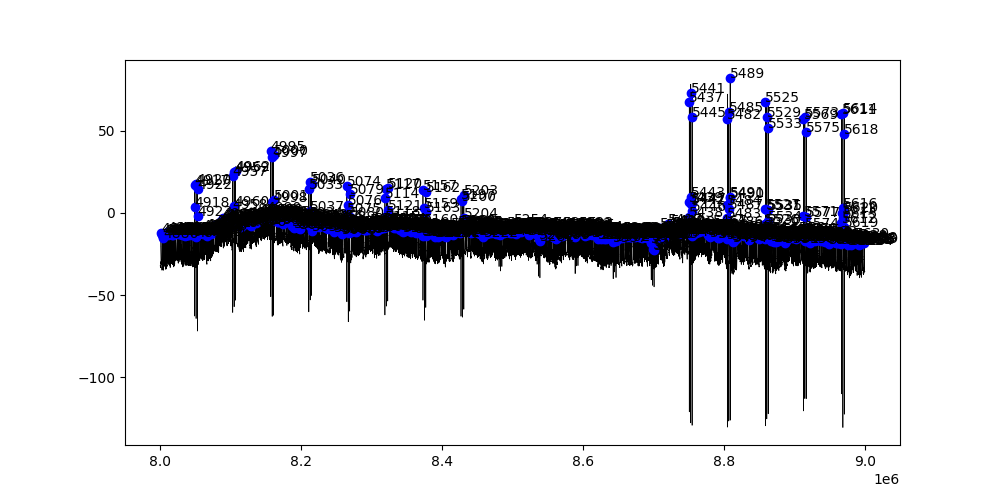

In [110]:
%matplotlib widget

# plot a portion of the raw_mV and filtered_mV with the detected spikes colored red if predicted label = 0 and blue if predicted label = 1
portion_start = 160 #seconds
portion_end = 180 #seconds

# seconds to tf index
portion_start = np.where(tf>portion_start)[0][0]
portion_end = np.where(tf>portion_end)[0][0]

# make arange from portion_start to portion_end
x = np.arange(portion_start, portion_end)
# plot
fig=plt.figure(figsize=(10,5))
plt.plot(x, raw_mV[portion_start:portion_end], 'k', linewidth=0.5)
# find all spikes that are >= portion_start and <= portion_end
spks_portion_idx1 = np.where(detected_spikes>=portion_start)[0][0]
spks_portion_idx2 = np.where(detected_spikes>=portion_end)[0][0]
spks_portion = detected_spikes[spks_portion_idx1:spks_portion_idx2]
# plot spikes as red x if predicted label = 0 and blue x if predicted label = 1
for i in range(len(spks_portion)):
    if labels_hat[i] == 0:
        plt.plot(spks_portion[i], raw_mV[spks_portion[i]], 'rx')
        # label the spike with the index in detected_spikes not spikes_portion
        plt.text(spks_portion[i], raw_mV[spks_portion[i]], str(i+np.where(detected_spikes>=portion_start)[0][0]))
    elif labels_hat[i] == 1:
        plt.plot(spks_portion[i], raw_mV[spks_portion[i]], 'bo')
        # label the spike with the index in detected_spikes
        plt.text(spks_portion[i], raw_mV[spks_portion[i]], str(i+np.where(detected_spikes>=portion_start)[0][0]))



In [111]:
# how many spikes got labelled as artifact?
print('Number of spikes labelled as artifact: ', len(np.where(labels_hat==0)[0]))
print('Number of spikes labelled as spike: ', len(np.where(labels_hat==1)[0]))

Number of spikes labelled as artifact:  0
Number of spikes labelled as spike:  25664


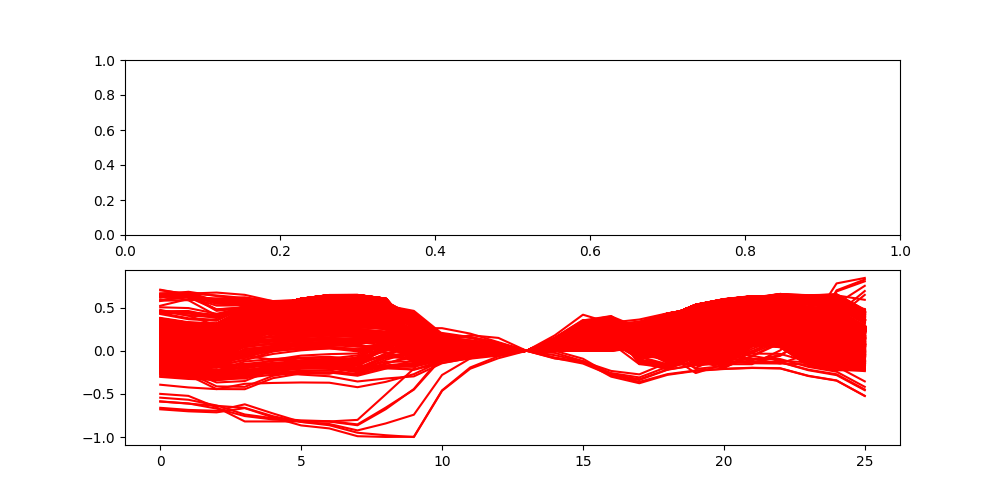

In [112]:
# show all the spikes that got labelled as artifact in a subplot on the left and the labelled as spike in a subplot on the right
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,5))
for i in range(len(np.where(labels_hat==0)[0])):
    ax1.plot(all_features_raw[i,:], 'r')

for i in range(len(np.where(labels_hat==1)[0])):
    ax2.plot(all_features_raw[i,:], 'r')